In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import time
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model

In [2]:
data = pd.read_csv('merged_iitp2.csv')
water = data.drop(['ELEC_diff','ELEC_before','ELEC','HOT_diff','HOT_before','HOT','WATER_diff','WATER_before'], axis=1)
hot = data.drop(['ELEC_diff','ELEC_before','ELEC','WATER_diff','WATER_before','WATER','HOT_diff','HOT_before'], axis=1)
elec = data.drop(['WATER_diff','WATER_before','WATER','HOT_diff','HOT_before','HOT','ELEC_diff','ELEC_before'], axis=1)

In [ ]:
# water = water.drop(['YEAR'], axis=1)
# elec = elec.drop(['YEAR'], axis=1)
# hot = hot.drop(['YEAR'], axis=1)

In [3]:
water['date'] = pd.to_datetime(water.iloc[:,:4])
elec['date'] = pd.to_datetime(elec.iloc[:,:4])
hot['date'] = pd.to_datetime(hot.iloc[:,:4])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


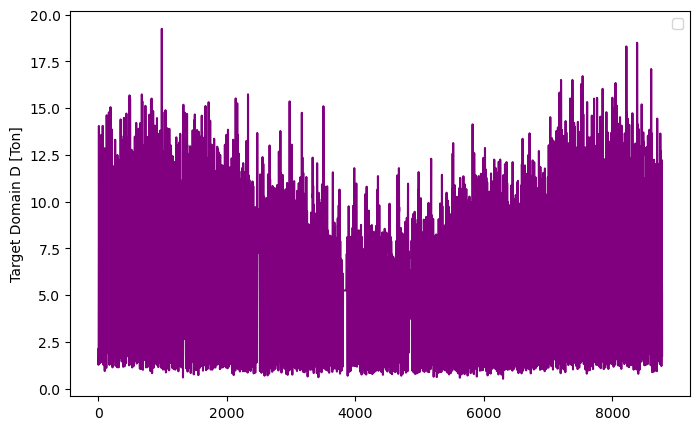

In [5]:
plt.figure(figsize=(8,5))
plt.ylabel('Target Domain D [Ton]')
plt.plot(water['WATER'], color='purple')
plt.legend()
plt.show()

In [ ]:
# plt.figure(figsize=(8,5))
# plt.ylabel('Target Domain E (elec consumption) []')
# plt.plot(elec['date'], elec['ELEC'], color='orange')
# plt.legend()
# plt.show()

In [ ]:
# plt.figure(figsize=(8,5))
# plt.ylabel('Target Domain F (hot consumption) []')
# plt.plot(hot['date'], hot['HOT'], color='red')
# plt.legend()
# plt.show()

##  For Scaling

In [ ]:
water_X = water.drop(['WATER'], axis=1)
water_Y = water[['WATER']]

scaler_water = MinMaxScaler()
scaler_water.fit(water_X)
scaled_water_X = scaler_water.transform(water_X)

new_water_X = pd.DataFrame(scaled_water_X, index=water_X.index, columns=water_X.columns)
new_water = pd.concat([new_water_X, water_Y], axis=1)

In [ ]:
elec_X = elec.drop(['ELEC'], axis=1)
elec_Y = elec[['ELEC']]

scaler_elec = MinMaxScaler()
scaler_elec.fit(elec_X)
scaled_elec_X = scaler_elec.transform(elec_X)

new_elec_X = pd.DataFrame(scaled_elec_X, index=elec_X.index, columns=elec_X.columns)
new_elec = pd.concat([new_elec_X, elec_Y], axis=1)

In [ ]:
hot_X = hot.drop(['HOT'], axis=1)
hot_Y = hot[['HOT']]

scaler_hot = MinMaxScaler()
scaler_hot.fit(hot_X)
scaled_hot_X = scaler_hot.transform(hot_X)

new_hot_X = pd.DataFrame(scaled_hot_X, index=hot_X.index, columns=hot_X.columns)
new_hot = pd.concat([new_hot_X, hot_Y], axis=1)

In [ ]:
input_water = new_water.iloc[:-1,]
target_water = new_water[['WATER']].iloc[1:]

trainX_water, testX_water, trainY_water, testY_water = train_test_split(input_water,target_water,test_size=0.3,shuffle=False,random_state=0)

In [ ]:
input_elec = new_elec.iloc[:-1,]
target_elec = new_elec[['ELEC']].iloc[1:]

trainX_elec, testX_elec, trainY_elec, testY_elec = train_test_split(input_elec,target_elec,test_size=0.3,shuffle=False,random_state=0)

In [ ]:
input = new_hot.iloc[:-1,]
target = new_hot[['HOT']].iloc[1:]

trainX_hot, testX_hot, trainY_hot, testY_hot = train_test_split(input,target,test_size=0.3,shuffle=False,random_state=0)

In [ ]:
def buildDataSet(input, target, seqLength):
    xdata = []
    ydata = []
    for i in range(len(input) - seqLength):
        tx = input.iloc[i:i+seqLength]
        ty = target.iloc[i+seqLength-1]
        xdata.append(tx)
        ydata.append(ty)
    return np.array(xdata), np.array(ydata)

In [ ]:
trainx_water, trainy_water = buildDataSet(trainX_water, trainY_water, 24)
testx_water, testy_water = buildDataSet(testX_water, testY_water, 24)
trainx_elec, trainy_elec = buildDataSet(trainX_elec, trainY_elec, 24)
testx_elec, testy_elec = buildDataSet(testX_elec, testY_elec, 24)
trainx_hot, trainy_hot = buildDataSet(trainX_hot, trainY_hot, 24)
testx_hot, testy_hot = buildDataSet(testX_hot, testY_hot, 24)

In [ ]:
def seq2seq_model(input_shape):
    model_input = tf.keras.layers.Input(shape=input_shape)

    # for feature extracting
    conv1 = tf.keras.layers.Conv1D(64, 1, activation='swish')(model_input)
    pool1 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='same')(conv1)
    conv2 = tf.keras.layers.Conv1D(32, 1, activation='swish')(pool1)
    pool2 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='same')(conv2)
    conv3 = tf.keras.layers.Conv1D(128, 1, activation='swish')(pool2)
    pool3 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='same')(conv3)

    # 인코더 - 디코더 선언
    encoder_lstm1 = tf.keras.layers.LSTM(64, return_sequences=True, activation='tanh')
    encoder_lstm2 = tf.keras.layers.LSTM(32, return_sequences=True, activation='tanh')
    encoder_lstm3 = tf.keras.layers.LSTM(128, return_state=True, return_sequences=True, activation='tanh')

    decoder_lstm1 = tf.keras.layers.LSTM(128, return_sequences=True, activation='tanh')
    decoder_lstm2 = tf.keras.layers.LSTM(32, return_sequences=True, activation='tanh')
    decoder_lstm3 = tf.keras.layers.LSTM(64, return_sequences=True, activation='tanh')

    # 인코더
    encoder_output_lstm1 = encoder_lstm1(pool3)
    encoder_output_lstm2 = encoder_lstm2(encoder_output_lstm1)
    encoder_output_lstm3, state_h, state_c = encoder_lstm3(encoder_output_lstm2)

    #디코더
    decoder_lstm1_output = decoder_lstm1(encoder_output_lstm3, initial_state=[state_h, state_c])
    decoder_lstm2_output = decoder_lstm2(decoder_lstm1_output)
    decoder_lstm3_output = decoder_lstm3(decoder_lstm2_output)

    flatten = tf.keras.layers.Flatten()(decoder_lstm3_output)
    model_output = tf.keras.layers.Dense(1, activation='swish')(flatten)
    
    model = tf.keras.models.Model(model_input, model_output)
    
    return model

In [ ]:
model = seq2seq_model(input_shape=(24, 12))
model.summary()

In [ ]:
# 모델 컴파일
earlystopping = EarlyStopping(monitor='loss', patience=50)
checkpoint = ModelCheckpoint(moniter='loss',filepath='new_hot_source.h5')
model.compile(loss='mae', optimizer=tf.keras.optimizers.Adamax(learning_rate=3e-4,clipnorm=1.0), metrics=['mae'])
# 모델 요약 정보 출력
hist = model.fit(trainx_hot, trainy_hot, epochs=200, batch_size=1024, callbacks=[earlystopping,checkpoint])

In [ ]:
model = load_model('new_hot_source.h5')
pred = model.predict(testx_water)
pred = np.reshape(pred,(-1,1))

real = np.array(testy_water)

In [ ]:
from sklearn.metrics import mean_absolute_error
print('MAE : ', round(mean_absolute_error(real, pred),4)) 

from sklearn.metrics import mean_squared_error
print('MSE : ', round(mean_squared_error(real, pred),4))

from sklearn.metrics import r2_score
print('R2 : ', round(r2_score(real, pred),4))

In [ ]:
plt.figure(figsize=(8,5))
plt.ylabel('Source Domain')
plt.plot(real, color='black', label='True')
plt.plot(pred, color='blue', label='Pred')
plt.legend()
plt.show()